In [2]:
from __future__ import division

import json
import pickle
import pandas as pd
import numpy as np
import math
from scipy.ndimage.interpolation import shift
from matplotlib import style
import matplotlib.pyplot as plt



style.use('ggplot')

min: 11.0


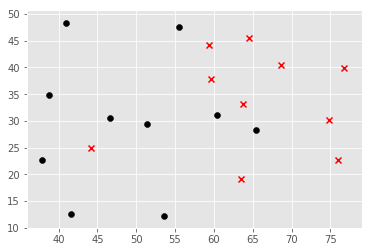



min: 12.0


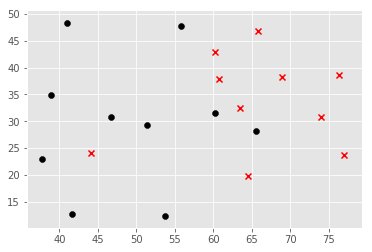



min: 13.0


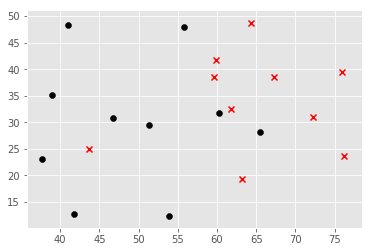



min: 14.0


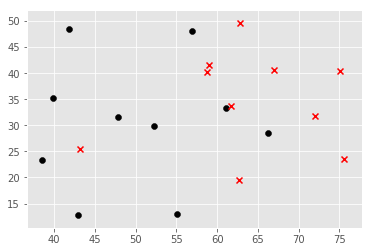



min: 15.0


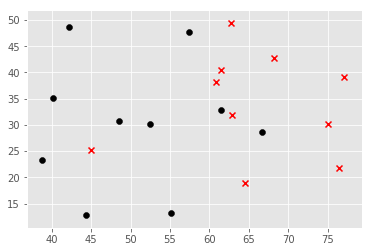



min: 16.0


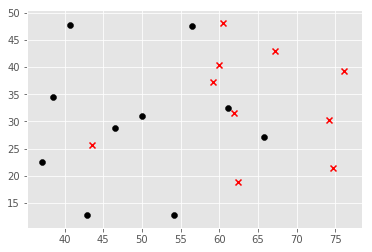



min: 17.0


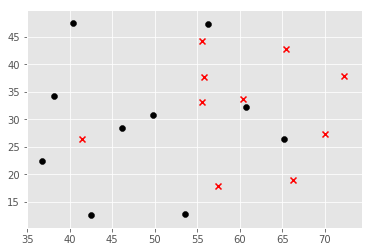



min: 18.0


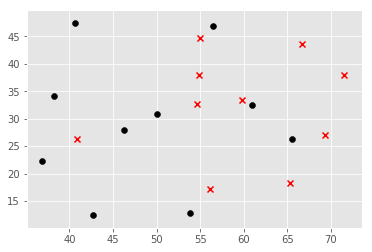



min: 19.0


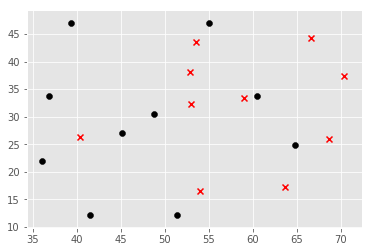



min: 20.0


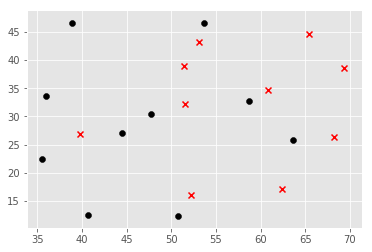



min: 21.0


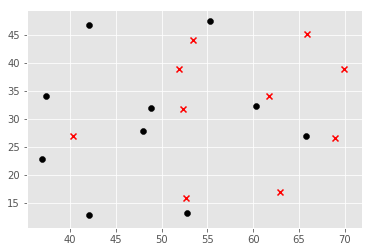



min: 22.0


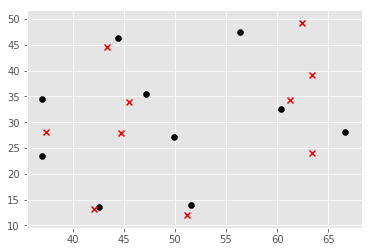



min: 23.0


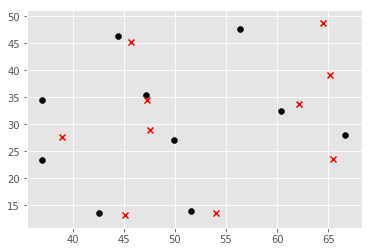



min: 24.0


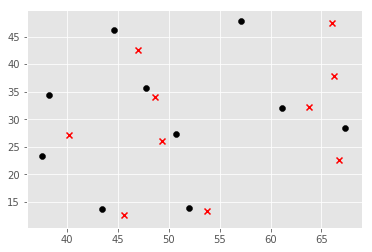



min: 25.0


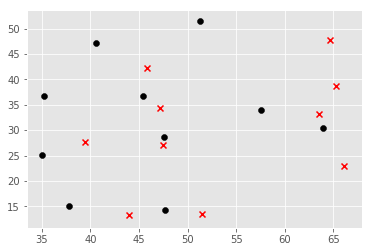



min: 26.0


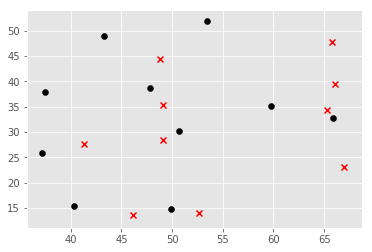



min: 27.0


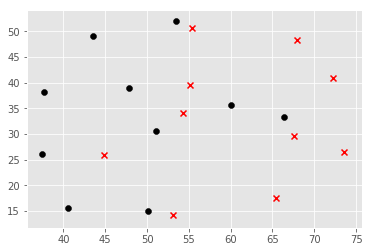



min: 28.0


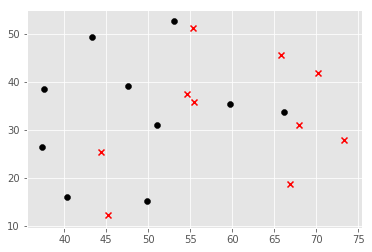



min: 29.0


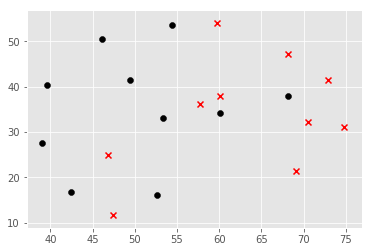



min: 30.0


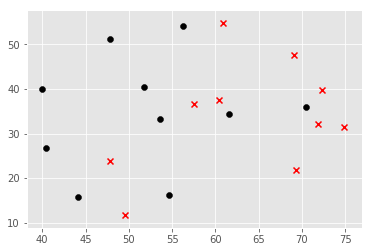



min: 31.0


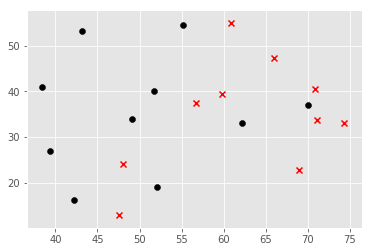



min: 32.0


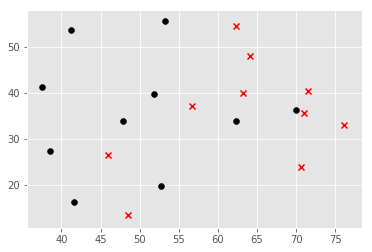



min: 33.0


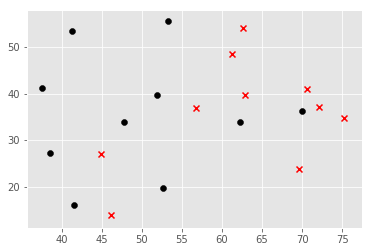



min: 34.0


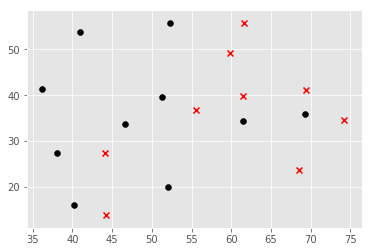



min: 35.0


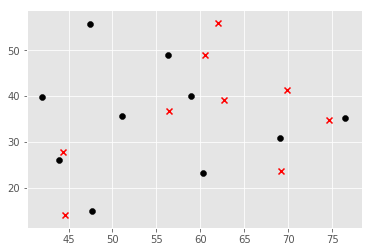



min: 36.0


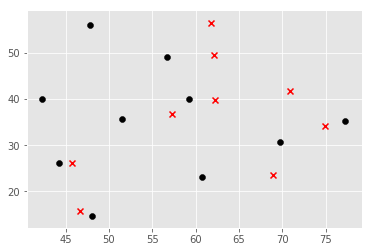



min: 37.0


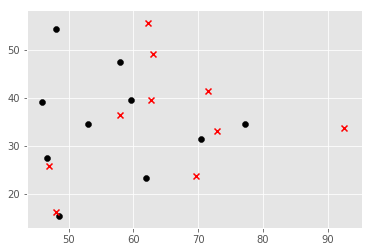



min: 38.0


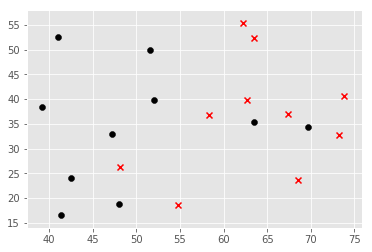



min: 39.0


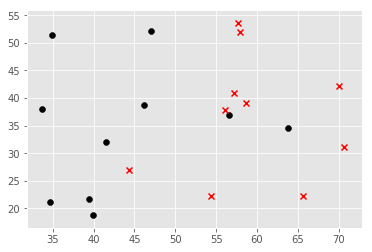



min: 40.0


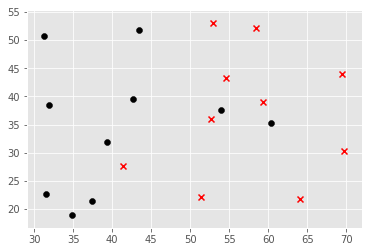



min: 41.0


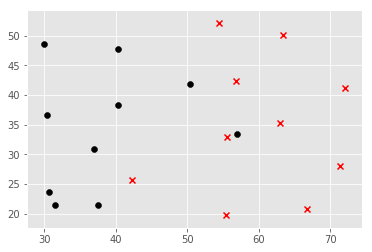



min: 42.0


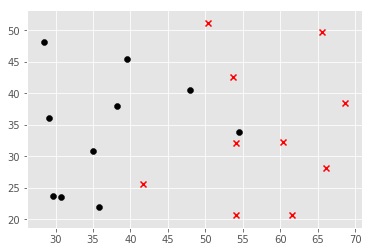



min: 43.0


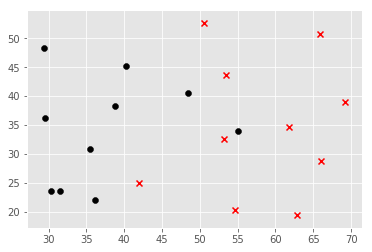



min: 44.0


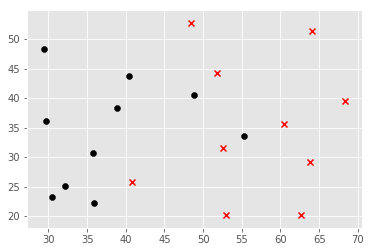



min: 45.0


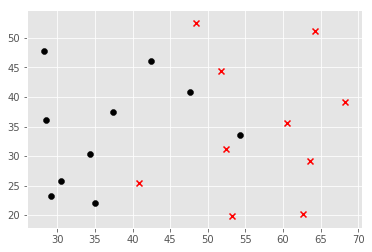



min: 46.0


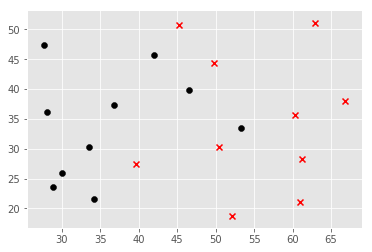



min: 47.0


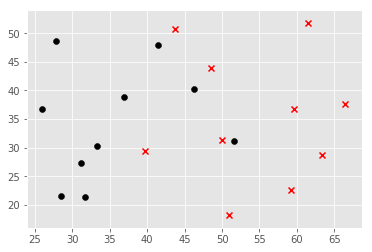



min: 48.0


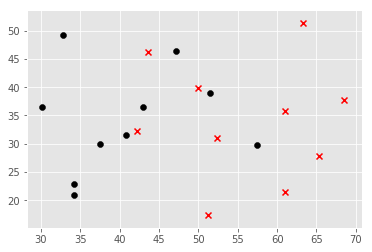



min: 49.0


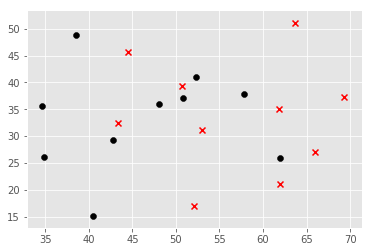



min: 46.0


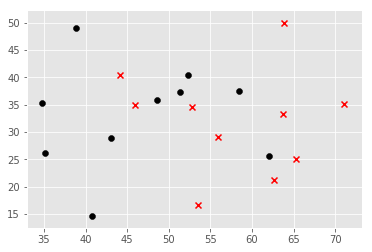



min: 47.0


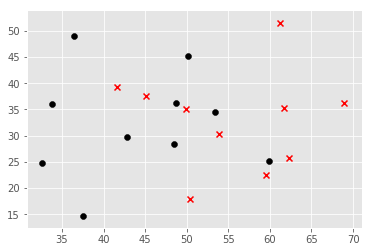



min: 48.0


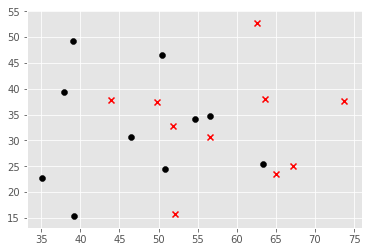



min: 49.0


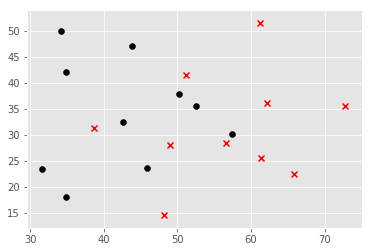



min: 50.0


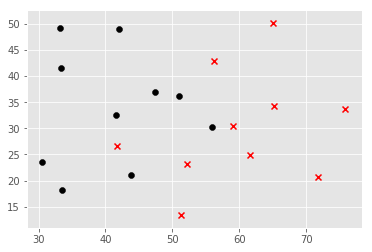



min: 51.0


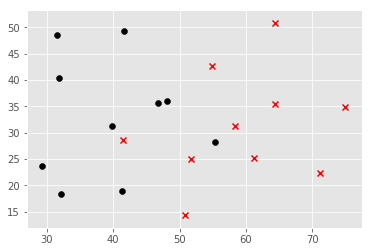



min: 52.0


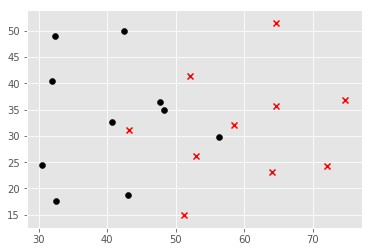



min: 53.0


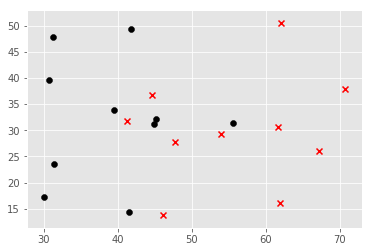



min: 54.0


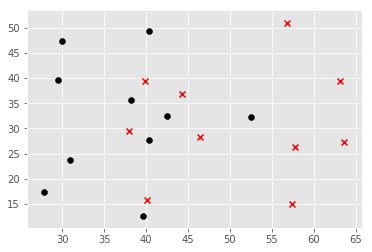



min: 55.0


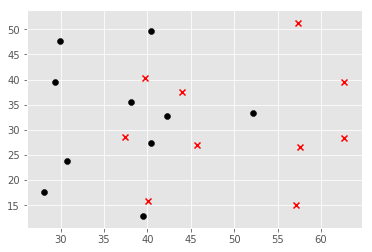



min: 56.0


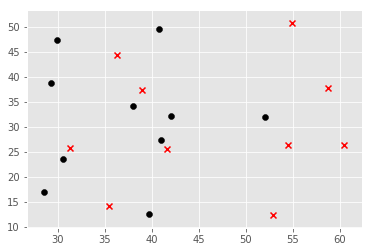



min: 57.0


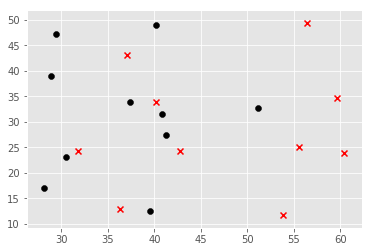



min: 58.0


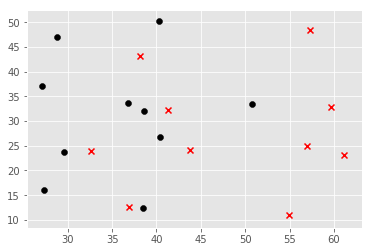



min: 59.0


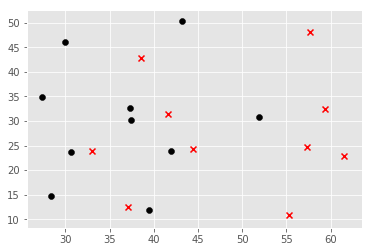



min: 60.0


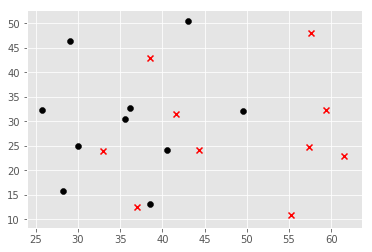



min: 61.0


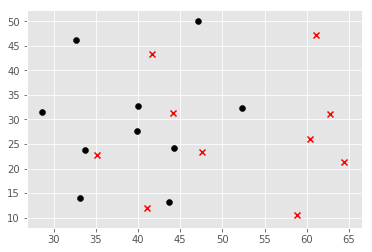



min: 62.0


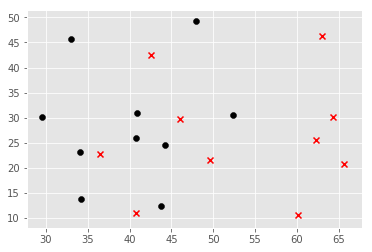



min: 63.0


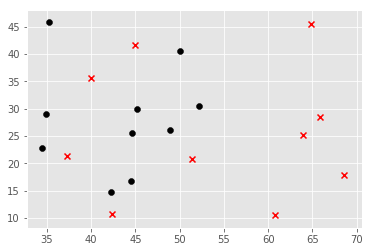



min: 64.0


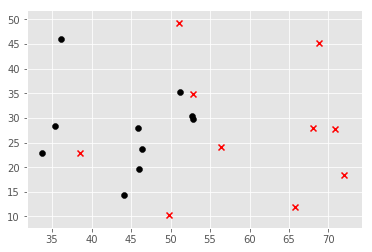



min: 65.0


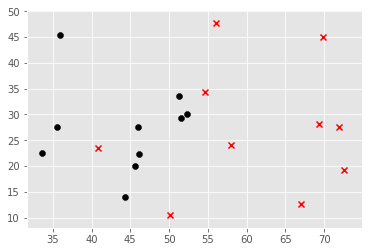



min: 66.0


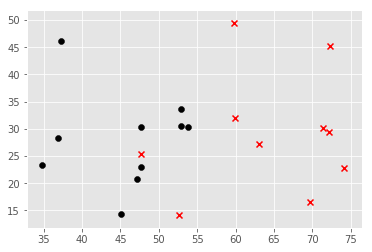



min: 67.0


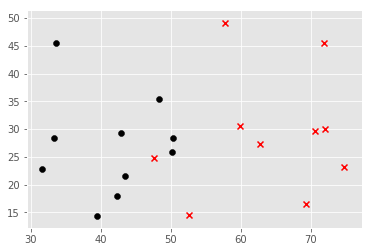



min: 68.0


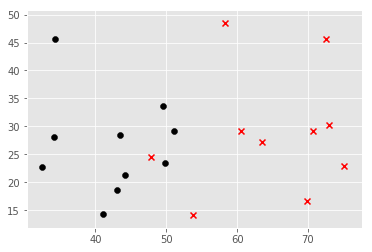



min: 69.0


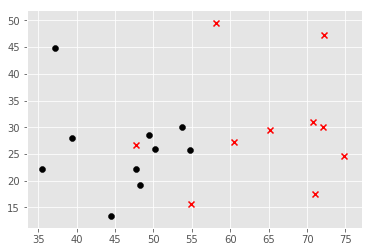



min: 70.0


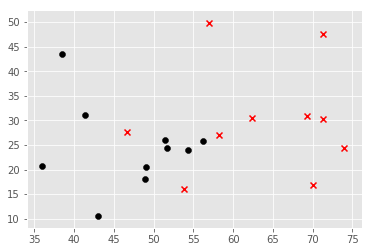



min: 71.0


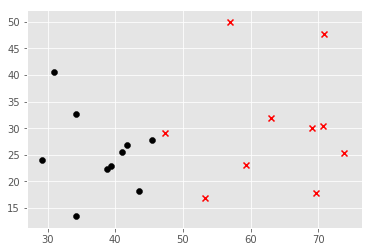



min: 72.0


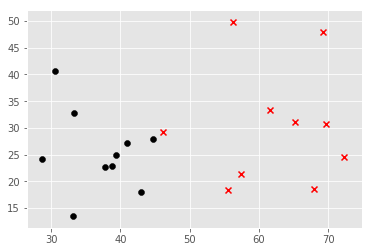



min: 73.0


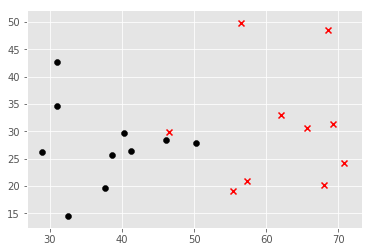



min: 74.0


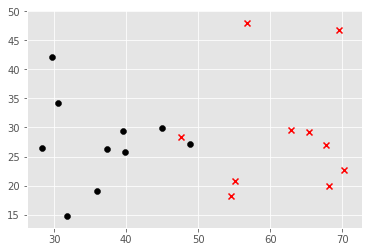



min: 75.0


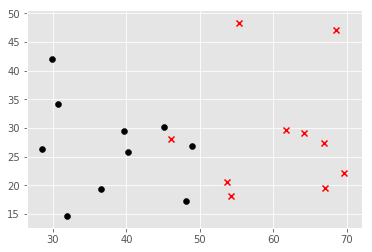



min: 76.0


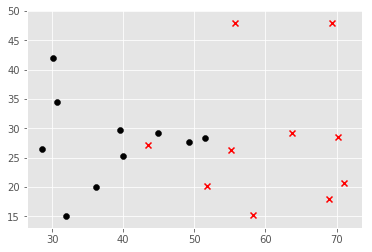



min: 77.0


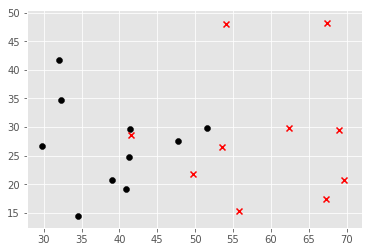



min: 78.0


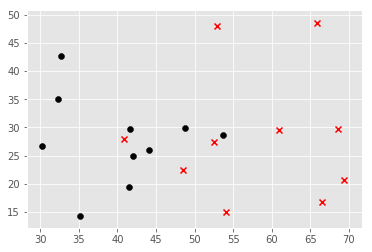



min: 79.0


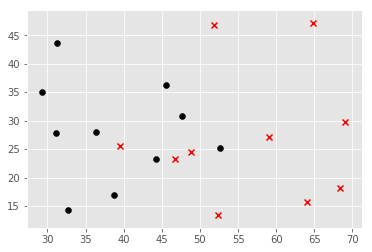



min: 80.0


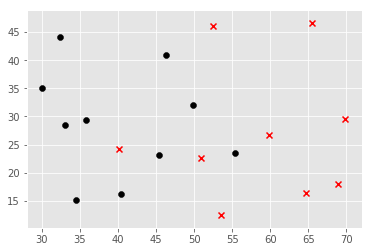



min: 81.0


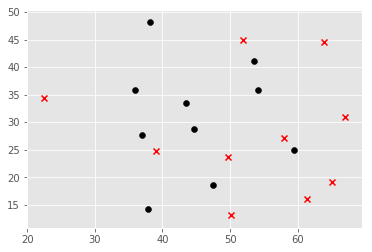



min: 82.0


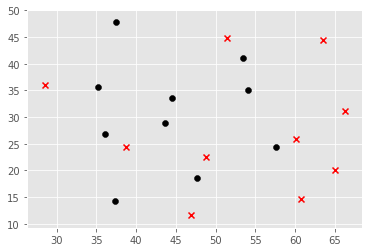



min: 83.0


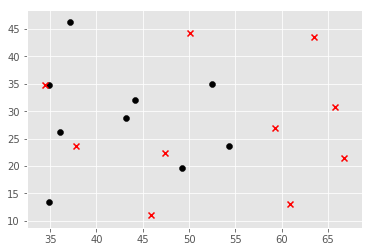



min: 84.0


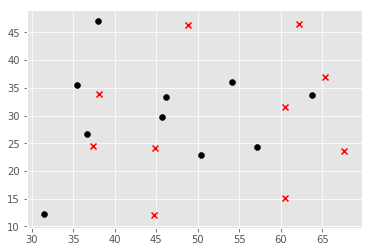



min: 85.0


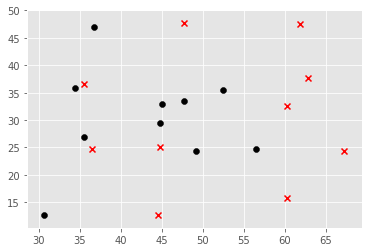



min: 86.0


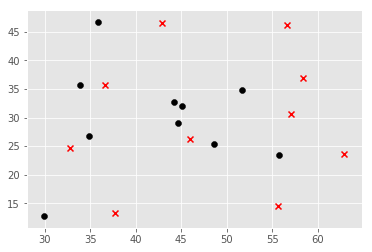



min: 87.0


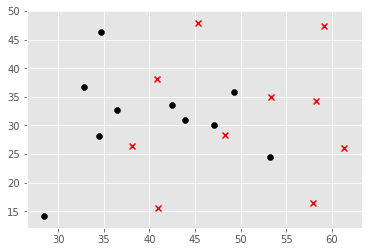



min: 88.0


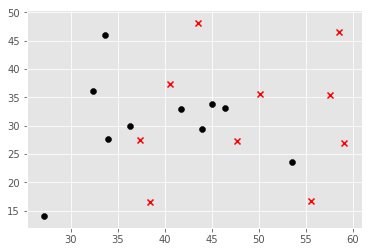



min: 89.0


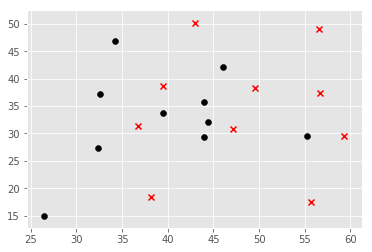



min: 90.0


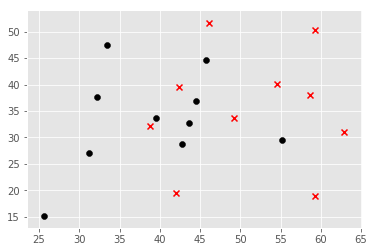



min: 91.0


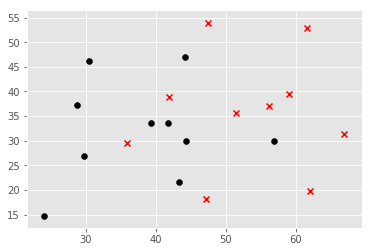



min: 92.0


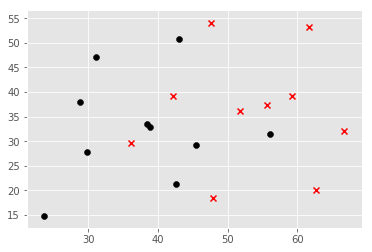



min: 93.0


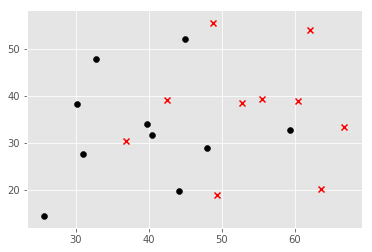



min: 94.0


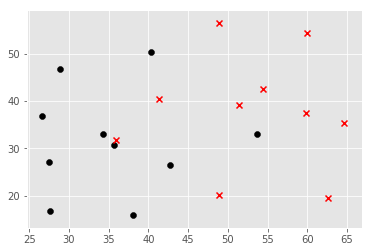

In [52]:


with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches_json = pd.read_json(matches_json)
    
matches = [60565]


no_team = 0
home_team = 0
away_team = 0
match_count = 1
minutes_step = 10



data_height = 6000 # number of seconds in per match
data_width = 128 # number of features for fector


for id in matches:
    with open('../data/match_' + str(id) + '/match_data_' + str(id) + '.json', 'r') as file:
        team = json.load(file)
      
        
    # defining 3 distinct id in game
    referee_id = 0
    home_team_id = int(team[1]['teamId'])
    away_team_id = int(team[2]['teamId'])
    
    # home player list
    home_team_player = []
    away_team_player = []
    
    # player dicts
    home_dict = {} 
    away_dict = {} 
    
    # players position ID 
    player_positionId = {'homeTeam' : {}, 'awayTeam' : {}}
    
    
    with open('../data/match_' + str(id) + '/roster_data_' + str(id) + '.json', 'r') as file:
        match_squad = json.load(file)
        
    for roaster in match_squad:
        if roaster['teamId'] == home_team_id:
            home_team_player.append(str(roaster['jerseyNumber']))
            player_positionId['homeTeam'][roaster['jerseyNumber']] = roaster['positionId'] 
            
        elif roaster['teamId'] == away_team_id:
            away_team_player.append(str(roaster['jerseyNumber']))
            player_positionId['awayTeam'][roaster['jerseyNumber']] = roaster['positionId']
            
            
    
    home_team_player.sort(key=int)
    home_val = np.arange(0, len(home_team_player))
    home_dict = dict(zip(home_team_player, home_val))
    home_dict_reverse = dict(zip(home_val, home_team_player))

    away_team_player.sort(key=int)
    away_val = np.arange(0, len(away_team_player))
    away_dict = dict(zip(away_team_player, away_val))
    away_dict_reverse = dict(zip(away_val, away_team_player))
    
    
    # home and away team player pos and activity count: 0-xpos, 1-ypos
    home_pos_count = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
    home_activity_count = np.zeros(shape=(len(home_team_player), 1), dtype=np.int)
    home_activity_count_all = np.zeros(shape=(len(home_team_player), 1), dtype=np.int)
    away_pos_count = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)
    away_activity_count = np.zeros(shape=(len(away_team_player), 1), dtype=np.int)
    away_activity_count_all = np.zeros(shape=(len(away_team_player), 1), dtype=np.int)

    # home and away team player count data for 10 min: 0-xpos, 1-ypos / 0-1min, 1-2min... 9-10min 
    home_pos_count_10min = np.zeros(shape=(len(home_team_player), 2, minutes_step), dtype=np.float)
    home_activity_count_10min = np.zeros(shape=(len(home_team_player), minutes_step), dtype=np.int)
    
    away_pos_count_10min = np.zeros(shape=(len(away_team_player), 2, minutes_step), dtype=np.float)
    away_activity_count_10min = np.zeros(shape=(len(away_team_player), minutes_step), dtype=np.int)
    
    
    # home and away team Mean pos data: 0-xpos, 1-ypos
    home_pos_mean = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
    
    away_pos_mean = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)
    
         
    # create array of x input data for every match
    x_intput = np.ndarray(shape=(data_height, data_width), dtype=np.float)        
            
    with open('../data/match_' + str(id) + '/per_sec_data_' + str(id) + '.json', 'r') as file:
        data_persec = json.load(file)
        
        
    # create first average positon data for assigning player position
    for t in data_persec:
        
        i = int(t['minute'])*60 + int(t['second'])
        x_pos = t['xpos']
        y_pos = t['ypos']
        team_id_t = int(t['teamId'])
        jersey_number_t = int(t['jerseyNumber'])
        has_ball_teamId_t = int(t['hasballTeamId'])
        
        if i==600:
            break
        
        first_10min = math.floor(i/60)
        
        
        
        if team_id_t == home_team_id:
            home_activity_count_all[home_dict[str(jersey_number_t)]] = +1
            if player_positionId['homeTeam'][jersey_number_t] == 1:
                home_pos_count_10min[home_dict[str(jersey_number_t)]][0][first_10min] += x_pos
                home_pos_count_10min[home_dict[str(jersey_number_t)]][1][first_10min] += y_pos
                home_activity_count_10min[home_dict[str(jersey_number_t)]][first_10min] +=1 
            
            elif has_ball_teamId_t == away_team_id:
                home_pos_count_10min[home_dict[str(jersey_number_t)]][0][first_10min] += x_pos
                home_pos_count_10min[home_dict[str(jersey_number_t)]][1][first_10min] += y_pos
                home_activity_count_10min[home_dict[str(jersey_number_t)]][first_10min] +=1
        
        elif team_id_t == away_team_id:
            away_activity_count_all[away_dict[str(jersey_number_t)]] = +1
            if player_positionId['awayTeam'][jersey_number_t] == 1:
                away_pos_count_10min[away_dict[str(jersey_number_t)]][0][first_10min] += x_pos
                away_pos_count_10min[away_dict[str(jersey_number_t)]][1][first_10min] += y_pos
                away_activity_count_10min[away_dict[str(jersey_number_t)]][first_10min] +=1 
            
            elif has_ball_teamId_t == home_team_id:
                away_pos_count_10min[away_dict[str(jersey_number_t)]][0][first_10min] += x_pos
                away_pos_count_10min[away_dict[str(jersey_number_t)]][1][first_10min] += y_pos
                away_activity_count_10min[away_dict[str(jersey_number_t)]][first_10min] +=1
    
    
    for player_home in range(0, len(home_team_player)):
        count = 0
        for minutes in range(0,10):
            home_pos_mean[player_home][0] += home_pos_count_10min[player_home][0][minutes]
            home_pos_mean[player_home][1] += home_pos_count_10min[player_home][1][minutes]
            count += home_activity_count_10min[player_home][minutes]

        if count!=0:
            home_pos_mean[player_home][0] /= count
            home_pos_mean[player_home][1] /= count
        else:
            home_pos_mean[player_home][0] = 0 
            home_pos_mean[player_home][1] = 0
            
    for player_away in range(0, len(away_team_player)):
        count = 0
        for minutes in range(0,10):
            away_pos_mean[player_away][0] += away_pos_count_10min[player_away][0][minutes]
            away_pos_mean[player_away][1] += away_pos_count_10min[player_away][1][minutes]
            count += away_activity_count_10min[player_away][minutes]

        if count!=0:
            away_pos_mean[player_away][0] /= count
            away_pos_mean[player_away][1] /= count
        else:
            away_pos_mean[player_away][0] = 0 
            away_pos_mean[player_away][1] = 0
            
    
    home_pos_mean = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
    away_pos_mean = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)
    
    # temporary t        
    tmp_t = 0 
        
    for d in data_persec:
        
        
        i = int(d['minute'])*60 + int(d['second'])
        x_pos = d['xpos']
        y_pos = d['ypos']
        team_id_t = int(d['teamId'])
        jersey_number_t = int(d['jerseyNumber'])
        has_ball_teamId_t = int(d['hasballTeamId'])
        
        
        # shifing last index of 10min arry (period of 10min) with last min data
        # and calculate mena position of each player each min based on previus 10 min
        if (i+1)%60 == 0 and tmp_t != i+1 and i>599:
            
            tmp_t = i+1

            home_pos_mean = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
            away_pos_mean = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)
            
            
            
            for player_home in range(0, len(home_team_player)):
                if home_activity_count_all[player_home] != 0:
                    count = 0
                    for minutes in range(0,minutes_step):
                        home_pos_mean[player_home][0] += home_pos_count_10min[player_home][0][minutes]
                        home_pos_mean[player_home][1] += home_pos_count_10min[player_home][1][minutes]
                        count += home_activity_count_10min[player_home][minutes] 
                    if count!=0:
                        home_pos_mean[player_home][0] /= count
                        home_pos_mean[player_home][1] /= count
                    else:
                        home_pos_mean[player_home][0] = 0 
                        home_pos_mean[player_home][1] = 0  
                else:
                    home_pos_mean[player_home][0] = 0 
                    home_pos_mean[player_home][1] = 0
                    
                jersey_n = home_dict_reverse[player_home]
                if player_positionId['homeTeam'][int(jersey_n)] == 1:
                    pass
                elif home_pos_mean[player_home][0]!=0 and home_pos_mean[player_home][1]!=0:
                    plt.scatter(home_pos_mean[player_home][0], home_pos_mean[player_home][1], marker="o", color="k", linewidths=0.5)
                    pass

            for player_away in range(0, len(away_team_player)):
                if away_activity_count_all[player_away] != 0:
                    count = 0
                    for minutes in range(0,minutes_step):
                        away_pos_mean[player_away][0] += away_pos_count_10min[player_away][0][minutes]
                        away_pos_mean[player_away][1] += away_pos_count_10min[player_away][1][minutes]
                        count += away_activity_count_10min[player_away][minutes]
                    if count!=0:
                        away_pos_mean[player_away][0] /= count
                        away_pos_mean[player_away][1] /= count
                    else:
                        away_pos_mean[player_away][0] = 0 
                        away_pos_mean[player_away][1] = 0 
                else:
                    away_pos_mean[player_away][0] = 0 
                    away_pos_mean[player_away][1] = 0
                    
                    
                jersey_n = away_dict_reverse[player_away]
                if player_positionId['awayTeam'][int(jersey_n)] == 1:
                    pass
                elif away_pos_mean[player_away][0]!=0 and away_pos_mean[player_away][1]!=0:
                    plt.scatter(away_pos_mean[player_away][0], away_pos_mean[player_away][1], marker="x", color="r", linewidths=0.5)
                    pass
                    

            print("min: " + str((i+1)/60))
            plt.show()
            print('\n')        
            
            
            for player_home in range(0, len(home_team_player)):
                home_pos_count_10min[player_home][0] = (shift(home_pos_count_10min[player_home][0], -1, cval=0))
                home_pos_count_10min[player_home][1] = (shift(home_pos_count_10min[player_home][1], -1, cval=0))
                home_activity_count_10min[player_home] = (shift(home_activity_count_10min[player_home], -1, cval=0))

                home_pos_count_10min[player_home][0][minutes_step-1] = home_pos_count[player_home][0]
                home_pos_count_10min[player_home][1][minutes_step-1] = home_pos_count[player_home][1]
                home_activity_count_10min[player_home][minutes_step-1] = home_activity_count[player_home]
                
            for player_away in range(0, len(away_team_player)):
                away_pos_count_10min[player_away][0] = (shift(away_pos_count_10min[player_away][0], -1, cval=0))
                away_pos_count_10min[player_away][1] = (shift(away_pos_count_10min[player_away][1], -1, cval=0))
                away_activity_count_10min[player_away] = (shift(away_activity_count_10min[player_away], -1, cval=0))

                away_pos_count_10min[player_away][0][minutes_step-1] = away_pos_count[player_away][0]
                away_pos_count_10min[player_away][1][minutes_step-1] = away_pos_count[player_away][1]
                away_activity_count_10min[player_away][minutes_step-1] = away_activity_count[player_away]
                
            

            # clear home team
            home_pos_count = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
            home_activity_count = np.zeros(shape=(len(home_team_player), 1), dtype=np.int)
            home_activity_count_all = np.zeros(shape=(len(home_team_player), 1), dtype=np.int)


            # clear away team
            away_pos_count = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)
            away_activity_count = np.zeros(shape=(len(away_team_player), 1), dtype=np.int)
            away_activity_count_all = np.zeros(shape=(len(away_team_player), 1), dtype=np.int)
            
    
        # getting players' and  referee's x,y coordinate on the pitch
        
        if team_id_t == home_team_id:
            home_activity_count_all[home_dict[str(jersey_number_t)]] +=1
            
            if player_positionId['homeTeam'][jersey_number_t] == 1:
                home_pos_count[home_dict[str(jersey_number_t)]][0] += x_pos
                home_pos_count[home_dict[str(jersey_number_t)]][1] += y_pos
                home_activity_count[home_dict[str(jersey_number_t)]] +=1

            elif has_ball_teamId_t == away_team_id:
                home_pos_count[home_dict[str(jersey_number_t)]][0] += x_pos
                home_pos_count[home_dict[str(jersey_number_t)]][1] += y_pos
                home_activity_count[home_dict[str(jersey_number_t)]] +=1 

        elif team_id_t == away_team_id:
            away_activity_count_all[away_dict[str(jersey_number_t)]] +=1
            
            if player_positionId['awayTeam'][jersey_number_t] == 1:
                away_pos_count[away_dict[str(jersey_number_t)]][0] += x_pos
                away_pos_count[away_dict[str(jersey_number_t)]][1] += y_pos
                away_activity_count[away_dict[str(jersey_number_t)]] +=1  
            
            elif has_ball_teamId_t == home_team_id:
                away_pos_count[away_dict[str(jersey_number_t)]][0] += x_pos
                away_pos_count[away_dict[str(jersey_number_t)]][1] += y_pos
                away_activity_count[away_dict[str(jersey_number_t)]] +=1 

        elif team_id_t == referee_id:
            pass
            # referee_pos_t['xpos']
            # referee_pos_t['ypos']
        
    
        
    

If one player's number of appearances during one minute is equal to zero, it implies that the player is out of the pitch (substituted, waiting for substitution, or receiving medical treatment). So we set his pos_mean (average coordinated per minute) to zero. But we keep his pos_10mins/ball_count_10mins just shifting the first element and updating its last element. Applying this we do not lose 10min positional mean data of the player if it comes back to pitch again.